## **Selección Extracción de Características (Backbones)**

#### Análisis resultados **Early Fusion**.

En este notebook, llevamos a cabo el análisis del **Grid Search** diseñado para identificar la combinación óptima de extractores de características (backbones) para nuestro proyecto de detección de Estrés.

Para este primer experimento, se ha fijado la arquitectura en un enfoque de **Early Fusion** (concatenación temprana a nivel de características). El Grid Search se ha compuesto de un total de **18 configuraciones distintas** (18 modelos a entrenar y evaluar). Todas las iteraciones comparten las siguientes condiciones base para garantizar una comparativa justa:
* **Ventana temporal fijada:** Ya que en este punto se pretende comparar los backbones en distintos modelos y combinaciones de los mismos para elegir los óptimos, para establecer igualdad en la comparación de modelos, se fija una venatana de 32 frames para vídeo, 11 segundos (550 (Wav2Vec)/350 (MFCCs) pasos) para audio, y de 64 tokens para texto. Más adelante, se estudiará la variación de estas ventanas. 
* **Función de pérdida ponderada:** `BCEWithLogitsLoss` con pesos dinámicos ajustados a la clase minoritaria para poder penalizar mucho más cuando el modelo falla en la clase minoritaria, y así combatir el fuerte desbalanceo del corpus.
* **Métricas de evaluación PRINCIPALES A ANALIZAR:** F1-Score (Macro), ROC-AUC y, específicamente, **Recall** de la clase 1 (**Estrés**). Estas son nuestras métricas más importantes debido a la naturaleza desbalanceada de nuestro dataset, y con las cuáles se evalúa el rendimiento real de nuestros modelos para escoger finalmente al ganador.

**El notebook se estructura de la siguiente manera:**
1. **Se muestran y analizan las métricas** extraídas de los reportes individuales (`.txt`) generados por cada modelo desde el servidor DGX.
2. **Se construye una **Tabla de Clasificación**** para identificar qué combinación de modelos (Vídeo + Audio + Texto) logra diferenciar y separar mejor a las muestras positivas (estrés) de las negativas.
3. **Se analizan visualmente** las Matrices de Confusión y Curvas ROC de los modelos más prometedores.
4. **Se selecciona al "Campeón Absoluto"**, el cual actuará como base inamovible para las siguientes fases de optimización temporal y fusiones complejas (Late y Attention Fusion).

**NOTA**: El entrenamiento y evaluación de los 18 modelos del Grid Search realizado, se han llevado a cabo en el servidor DGX, desde el cuál se han cargado los resultados en local. 

### **1. Evaluación rendimiento de los modelos.**

Métricas a analizar:

* **F1-Score Macro**: Es la media de rendimiento del modelo asumiendo que todas las clases tienen exactamente la misma importancia, independientemente del número de muestras de cada una. Es la métrica más estricta ya que, al tener un dataset tan desbalanceado, un modelo que clasifique todo como **"No-Estrés (0)"** tendría un buen F1 **en esa clase**, pero un F1 de 0 o muy pequeño para la clase **Estrés**, lo que hace que el **F1 Score Macro** se hunda. Con esto, seleccionamos aquellos modelos que presenten una buena *media armónica* para ambas clases. 

$$Precision=\frac{TP}{TP+FP}$$
$$F1_{clase}=2\times\frac{Precision\times Recall}{Precision+Recall}$$
$$F1_{Macro}=\frac{F1_{Estres}+F1_{No\_Estres}}{2}$$

* **Recall clase positiva (Estrés)**: Proporción de casos positivos reales que el modelo ha logrado detectar frente al total de casos positivos reales que se encontraban en los datos de *test*. Es decir, del total de **956** instancias con **Estrés**, cuáles de esas ha logrado detectar correctamente nuestro modelo. Se debe maximizar esta métrica, ya que, en el ámbito clínico/psicológico como nuestro caso, maximizarla conlleva minimizar los diagnósticos perdidos. 

$$Recall_{Estres}=\frac{TP}{TP+FN}$$

* **ROC-AUC**: Representa la probabilidad de que el modelo asigne una puntuación más alta a una instancia positiva aleatoria del dataset frente a una instancia negativa. Permite estudiar si los backbones consiguen diferenciar instancias estresadas frente a no estresadas eficazmente.

$$TPR=\frac{TP}{TP+FN}$$
$$FPR=\frac{FP}{FP+TN}$$
$$ROC\_AUC=\int_{0}^{1}TPR(FPR)d(FPR)$$

**TPR: Tasa de Verdaderos Positivos**.\
**FPR: Tasa de Falsos Positivos**.

Inicialmente, se crea el código que leerá cada uno de los reportes con los resultados en *test* de cada uno de los 18 modelos, y se crea un **dataframe** con todas las métricas iniciales extraídas, para luego prestar atención a las métricas que acabamos de describir para seleccionar al ganador.

#### **Filtro para ordenar la Tabla de Clasificación**:
En el siguiente orden, se utilizan las métricas para ordenar la tabla y seleccionar al modelo ganador:

1. **F1-Score Macro**: En el *top* se encontrarán los modelos que mejor rendimiento consiguen en **ambas** clases a la vez (modelos más equilibrados e imparciales).

2. **ROC-AUC**: Ante un **F1-Score Macro** igual, se desempata con esta métrica, ya que evalúa que los backbones del modelo sepan diferenciar entre las instancias positivas y negativas adecuadamente, es decir, que hayan construido un espacio latente más limpio y robusto que otros backbones de otros modelos, separando mejor las muestras de ambas clases.

3. **Recall de la clase positiva (Estrés)**: Ante igualdad en **F1-Score Macro** y **ROC-AUC**, gana el modelo que tenga esta métrica más alta, porque es el que deja "escapar" a menos muestras estresadas, en un contexto clínico/psicológico como es el caso de las emociones y en concreto el estrés, donde se le da prioridad a clasificar a la clase positiva antes que cometer un "diagnóstico perdido".


In [8]:
# Carga de las librerías necesarias:
import os
import glob
import re
import pandas as pd
from IPython.display import Image, display

In [7]:
# Rutas donde están los 18 reportes:
ruta_resultados = "../resultados/resultados_test_earlyfusion/"
patron_archivos = os.path.join(ruta_resultados, "reporte_final_test_*64.txt")

datos_modelos = []# Lista para guardar los datos de cada modelo

# 2. Recorremos todos los archivos que coincidan con el patrón indicado
for archivo in glob.glob(patron_archivos):
    with open(archivo, 'r', encoding='utf-8') as f:
        contenido = f.read()
        
        # --- EXTRACCIÓN MEDIANTE EXPRESIONES REGULARES ---
        
        # Nombre del modelo (extraído del nombre del archivo o de la primera línea del reporte)
        # Busca lo que hay después de 'early_' y antes de '.pth'
        match_modelo = re.search(r'early_(.*?)\.pth', contenido)
        modelo_nombre = match_modelo.group(1) if match_modelo else os.path.basename(archivo) # Si no se encuentra el patrón, se usa el nombre del archivo como fallback
        
        # Métrica: ROC-AUC
        match_auc = re.search(r'ROC-AUC:\s*([\d\.]+)', contenido) # Busca 'ROC-AUC:' seguido de espacio... Y de un número (con posible decimal), seguido de un espacio o fin de línea
        roc_auc = float(match_auc.group(1)) if match_auc else None
        
        # Métrica: F1-Score Macro
        # Se busca que comience por 'macro avg', salta precisión y recall (que son las dos primeras columnas), y coge el tercer número (f1-score)
        match_macro = re.search(r'macro avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)', contenido)
        f1_macro = float(match_macro.group(1)) if match_macro else None
        
        # Métrica: Recall y F1-Score de la clase "Estrés"
        # Se busca que comience por 'Estrés', ignora el primer número (precisión) y coge el 2º (recall) y 3º (f1)
        match_estres = re.search(r'Estrés\s+[\d\.]+\s+([\d\.]+)\s+([\d\.]+)', contenido)
        recall_estres = float(match_estres.group(1)) if match_estres else None
        f1_estres = float(match_estres.group(2)) if match_estres else None
        
        # Métrica: Inferencia media
        match_inf = re.search(r'Inferencia media:\s*([\d\.]+)', contenido)
        inferencia = float(match_inf.group(1)) if match_inf else None
        
        # Métrica: F1-Score Weighted (Solo lo incluísmos para tenerlo en cuenta, aunque no se usará para ordenar la clasificación ni elegir el mejor modelo)
        match_weighted = re.search(r'weighted avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)', contenido)
        f1_weighted = float(match_weighted.group(1)) if match_weighted else None

        # Se guardan finalmente en el diccionario con los resultados:
        datos_modelos.append({
            'Backbones': modelo_nombre,
            'ROC-AUC': roc_auc,
            'F1-Macro': f1_macro,
            'Recall (Estrés)': recall_estres,
            'F1 (Estrés)': f1_estres,
            'F1-Weighted': f1_weighted,
            'Inferencia (ms)': inferencia
        })


df_resultados = pd.DataFrame(datos_modelos)

# ORDENAMOS la tabla de modelos de la siguiente manera:
# 1º F1-Macro (Mayor a menor)
# 2º ROC-AUC (Mayor a menor)
# 3º Recall (Estrés) (Mayor a menor)
# 4º Inferencia media en ms (Menor a mayor, porque queremos el más rápido/eficiente)
df_ordenado = df_resultados.sort_values(
    by=['F1-Macro', 'ROC-AUC', 'Recall (Estrés)', 'Inferencia (ms)'], 
    ascending=[False, False, False, True] # El último True es porque queremos que la inferencia sea menor, es decir, más rápida
).reset_index(drop=True)

# Mostramos los 10 mejores modelos
df_ordenado.head(10)

,Backbones,ROC-AUC,F1-Macro,Recall (Estrés),F1 (Estrés),F1-Weighted,Inferencia (ms)
0,resnet32_wav2vec11s_roberta64,0.8033,0.7023,0.8216,0.8506,0.7840,4.78
1,efficientnet32_mfcc11s_bert64,0.8093,0.6964,0.7864,0.8358,0.7732,0.95
2,efficientnet32_wav2vec11s_bert64,0.8113,0.6956,0.7779,0.8324,0.7710,4.65
3,resnet32_mfcc11s_roberta64,0.7906,0.6933,0.7870,0.8350,0.7714,0.91
4,resnet32_mfcc11s_bert64,0.8159,0.6918,0.7495,0.8203,0.7626,0.94
5,resnet32_wav2vec11s_bert64,0.7852,0.6894,0.7985,0.8379,0.7712,4.75
6,vit32_wav2vec11s_roberta64,0.8043,0.6751,0.7367,0.8090,0.7489,4.71
7,vit32_wav2vec11s_bert64,0.7992,0.6684,0.7068,0.7943,0.7378,4.62
8,efficientnet32_mfcc11s_roberta64,0.7874,0.6674,0.7334,0.8049,0.7431,0.93
9,efficientnet32_wav2vec11s_roberta64,0.7919,0.6652,0.7113,0.7950,0.7367,4.65


En esta Tabla de Clasificación con los 10 mejores modelos de acuerdo a la estrategia de ordenación llevada a cabo, se revelan tendencias claras:

- Claramente, el modelo ganador sin duda es el formado por los backbones de **ResNet** para vídeo (ventana fijada inicialmente a 32 frames para todos los modelos), **Wav2Vec** para audio (con una ventana temporal de 11s, lo que equivale a unos 550 pasos de tiempo, fijado inicialmente igual para todos los modelos), y **RoBERTa** con ventana de  **64** tokens fijada. 

    - Alcanza el mejor equilibrio global con un **F1-Macro** de **0,7023** y un área **ROC-AUC** de **0,8033**. Su rendimiento en la clase minoritaria es muy bueno, logrando un **Recall** de **Estrés** del **82,16%**, donde solo un **17,84%** de las muestras positivas no son detectadas (perdidas), siendo un número muy bajo. 

    - **Esta configuración se establece como *baseline* definitivo para los siguientes experimentos de fusión y atención, además de los estudios de ablación y variación de ventanas.**

Ahora, analizamos una por una, los extractores de cada modalidad y las tendencias observadas:

* **Vídeo (CNNs frente a Transformers)**: Las Redes Neuronales Convolucionales (CNN) dominan sin ninguna duda ante la arquitectura Transformer de **ViT**. Esto confirma lo que los propios autores de **ViT** dejan indicado en su *paper*, y es que este modelo, ante arquitecturas tradicionales, ante datasets pequeños como es nuetro caso, no llega a superarlas en rendimiento. Para esta estrategia de concatenación temprana (*Early Fusion*), la extracción de características puramente espaciales de las CNN se alinea mejor con el audio y el texto que los parches de atención global del **ViT (Vision Transformer)**.
Entre **ResNet** y **EfficientNet**, ambas obtienen muy buenos resultados, pero **ResNet** logra una ligera ventaja técnica sobre **EfficientNet**, indicando que la arquitectura residual de **ResNet** consigue extraer microexpresiones faciales de estrés de forma más robusta, pero a pesar de esto, **EfficientNet** se consolida como una alternativa eficiente. 


* **Texto**: En esta modalidad, se da un caso curioso, y es que los modelos lingüísticos de **BERT** y **RoBERTa** demuestran un rendimiento casi idéntico (todos los modelos líderes o bien presentan como backbone **BERT** o bien **RoBERTa** con resultados similares en las métricas). Aunque **RoBERTa** lidera en el modelo ganador, **BERT** aparece en las posiciones 2, 3 y 5. Ambos Transformers son extractores semánticos altamente robustos para esta tarea. **DeBERTa** por el contrario queda fuera del *Top 10*, a pesar de ser una arquitectura teóricamente superior, pero parece que dicha misma complejidad matemática parece jugar en su contra en la etapa de *Early Fusion*. Sus representaciones semánticas resultan demasiado complejas para alinearse linealmente en la concatenación con el vídeo y audio, demostrando que modelos consolidados como **BERT/RoBERTa** generalizan mejor evitando sobreajuste. 

* **Audio**: Aquí, se observa algo curioso, ya que como estándar en la industria, conformado el **Top 1**, se encuentra **Wav2Vec**, pero los coeficientes acústicos tradicionales, o como los hemos llamado, *handcrafted*, demuestran una muy alta competitividad, ocupando los puestos 2,4 y 5. 
El segundo modelo (`efficientnet32_mfcc11s_bert64`) presenta una ligera caída en **F1-Macro** frente al ganador (0,6964 frente a 0,7023), pero ofrece un tiempo de inferencia de **0,95** ms frente a los **4,78 ms** del ganador. Es deicr, sustituir **Wav2Vec** por **MFCC** hace que el sistema sea 5 veces más rápido sacrificando apenas un **0,5%** de rendimiento global. Además, sorprende que el rendimiento de **MFCC**, con tan solo **15 dimensiones** de sus vectores de embedding, llegue a condensar muy bien la información acústica frente a las **2048** dimensiones de los embeddings de **Wav2Vec**. Por tanto, dependiendo de los recursos de *hardware* disponibles, esta alternativa ligera estaría plenamente justificada. 

### **MODELO GANADOR**. **BACKBONES ELEGIDOS**.

`resnet32_wav2vec11s_roberta64`:

* **Backbone Vídeo**: **ResNet50**.

* **Backbone Audio:**: **Wav2Vec 2.0**.

* **Backbone Texto**: **RoBERTa**.

Se muestra el reporte final con todas las métricas obtenidas para el modelo ganador, con los gráficos de la matriz de confusión y **ROC-AUC** para *test*:


MODELO: ./modelo_estres_early_resnet32_wav2vec11s_roberta64.pth
Parámetros: 9913089
Inferencia media: 4.78 ms
ROC-AUC: 0.8033
              precision    recall  f1-score   support

   No Estrés     0.8817    0.8216    0.8506      3301
      Estrés     0.5013    0.6192    0.5540       956

    accuracy                         0.7761      4257
   macro avg     0.6915    0.7204    0.7023      4257
weighted avg     0.7962    0.7761    0.7840      4257



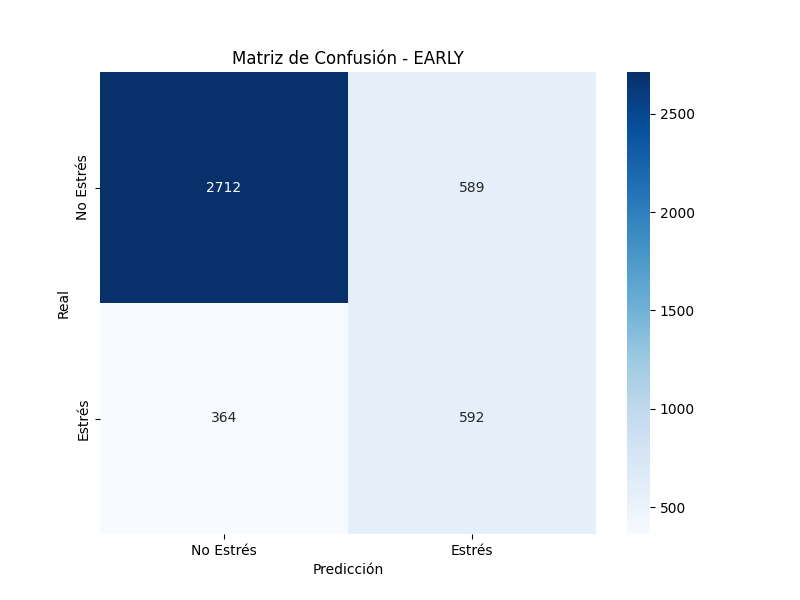

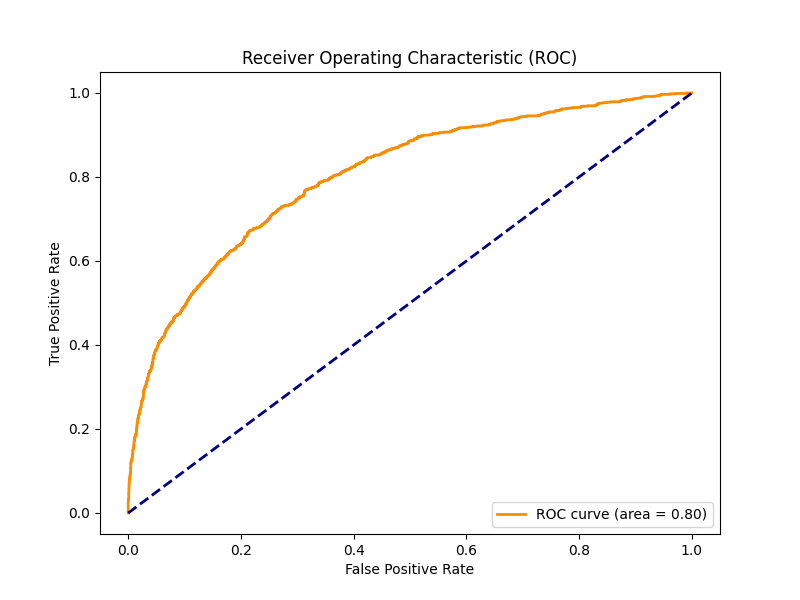

In [11]:
ruta_reporte = "../resultados/resultados_test_earlyfusion/reporte_final_test_modelo_early_resnet32_wav2vec11s_roberta64.txt"
with open(ruta_reporte, 'r', encoding='utf-8') as f:
    print(f.read())

ruta_matriz = "../resultados/resultados_test_earlyfusion/Fig_5_1_1_matriz_confusion_modelo_early_resnet32_wav2vec11s_roberta64.png"
ruta_roc = "../resultados/resultados_test_earlyfusion/Fig_5_1_2_curva_roc_modelo_early_resnet32_wav2vec11s_roberta64.png"

display(Image(filename=ruta_matriz, width=500))

display(Image(filename=ruta_roc, width=500))